In [2]:
#COPY THE CONTENT FROM URL AND WRITE TO LOCAL FILE
import urllib
response = urllib.urlopen('http://deeplearning.net/tutorial/code/utils.py')
content = response.read()
target = open('utils.py', 'w')
target.write(content)
target.close()

In [3]:
#IMPORT REQUIRED LIBRARIES
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#SPLIT MNIST TO TRAIN AND TEST DATASETS
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_x, train_y, test_x, test_y = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
#Define the layers - Visible Layer, Hidden Layer and Weights
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [500])
W = tf.placeholder("float", [784, 500])

In [34]:
#FORWARD PASS - Visible to Hidden and Sample from the Sigmoid Activated Hidden Layer
v0 = tf.placeholder("float", [None, 784])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X

In [35]:
#BACKWARD PASS - Hidden to Visible and Sample from the Sigmoid Activated Visible Layer
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [36]:
#BackProp into Weights Requires Positive Gradient & Negative Gradient
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [37]:
err = tf.reduce_mean(tf.square(v0-v1))

In [38]:
cur_w  = np.zeros([784, 500], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)
prv_w  = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)
sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [39]:
sess.run(err, feed_dict={v0: train_x, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48118877

PERFORM MINI-BATCH GRADIENT DESCENT

Epoch: 0 reconstruction error: 0.063585
Epoch: 1 reconstruction error: 0.054674
Epoch: 2 reconstruction error: 0.051127
Epoch: 3 reconstruction error: 0.048546
Epoch: 4 reconstruction error: 0.046955


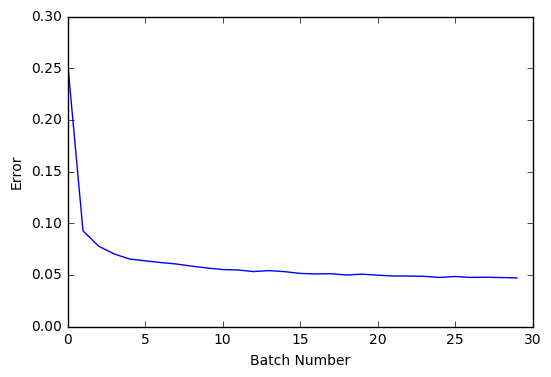

In [43]:
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(train_x), batchsize), range(batchsize, len(train_x), batchsize)):
        batch = train_x[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={v0: train_x, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print 'Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1]
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()
            

VISUALIZING THE TRAINED WEIGHT MATRIX

>Here, we want to visualize all weight vectors connecting the visble units to each hidden unit.
Each trained weight vector will will determine if a certain hidden unit is activated given the input image.
After training, each hidden unit will become sensitive to certain features in the inputs and these features are
encoded in the weight vecotrs.  
Here we have 500 hidden units, thus, each unit will have a weight vector comprising a flattened image of size 784.
These are visualized below

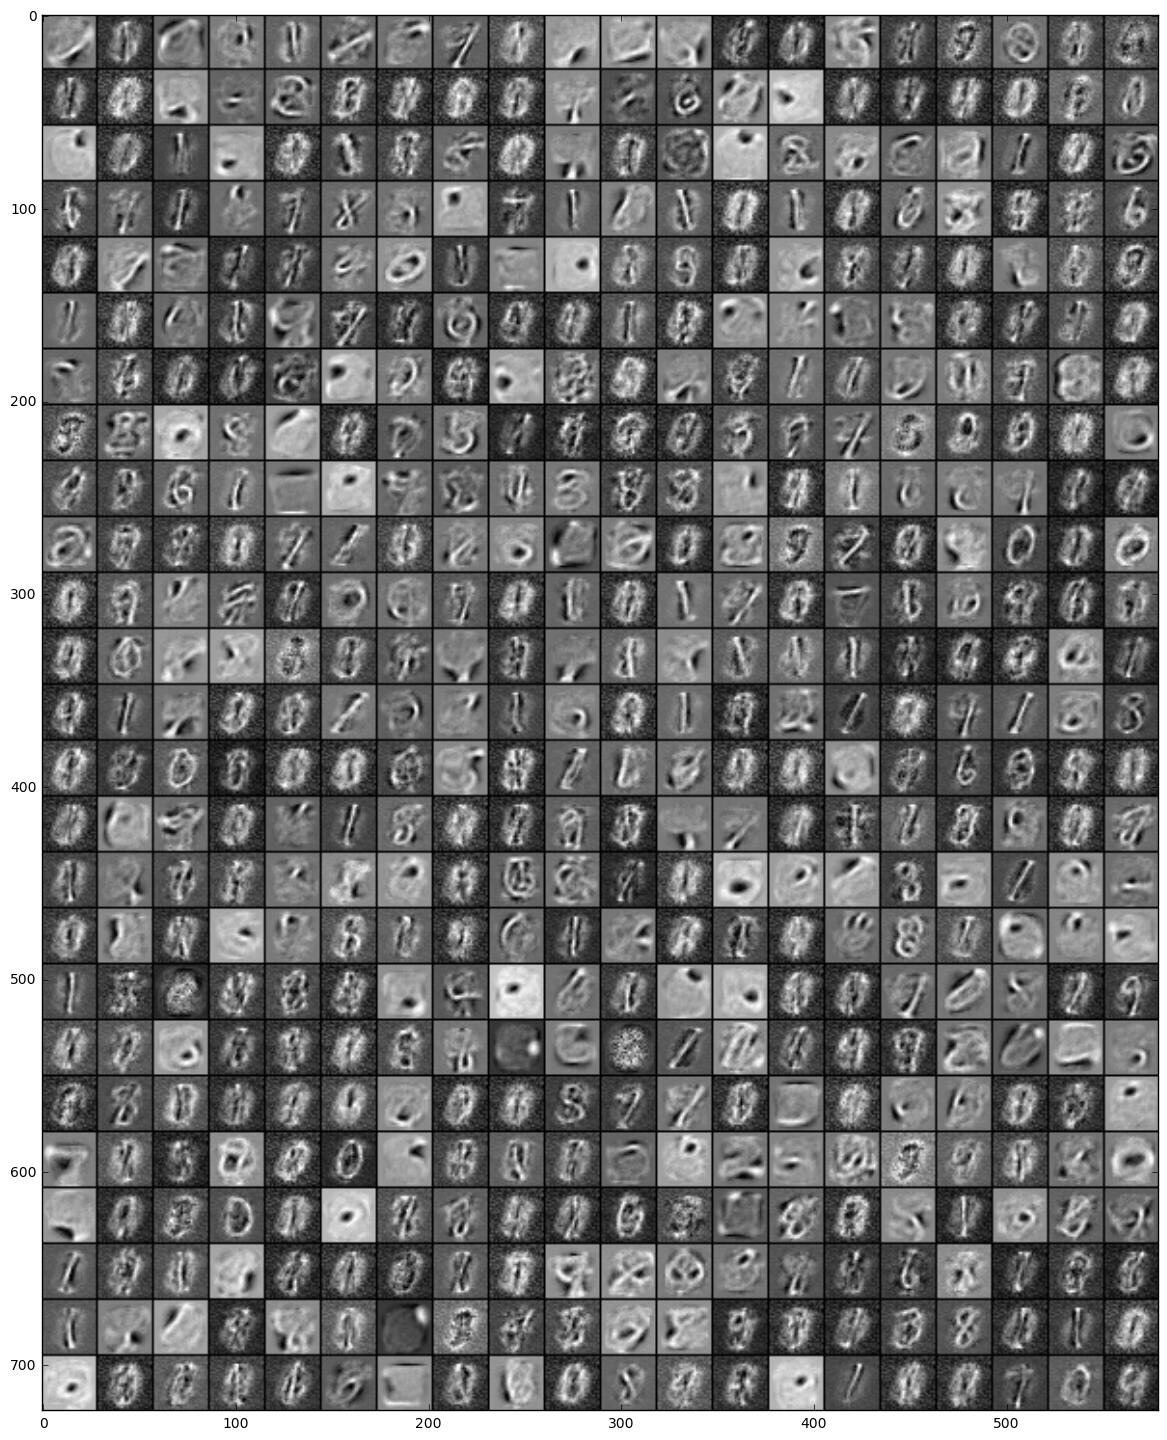

In [110]:
#VISUALIZING THE TRAINED WEIGHT MATRIX TRANSPOSE OF DIM 500*784
#Here we have 500 rows, each comprising a flattened image of size 784
#i.e. We will visualize the weight vector which connects all the visible units to one hidden unit
#Therefore, we have 500 images, each of 784 pixels

tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(25, 20), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(25, 20), tile_spacing=(1, 1)))

### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

VISUALIZING A SINGLE WEIGHT VECTOR
>Note that the pixels/units closer to 1 (white) in the weight vector will allow the corresponding units in the input image to trigger/activate the hidden unit/neuron. The pixels/units closer to 0 will block the corresponding units/pixels from the input to affect the hidden unit/neuron. Therefore, the weight vector will determine which features from the input images will trigger/activate the neurons  

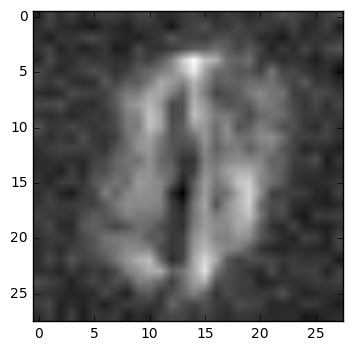

In [118]:
#VISUALIZING A SINGLE WEIGHT-VECTOR OF DIM 1*500

from PIL import Image
image = Image.fromarray(tile_raster_images(X=cur_w.T[1:2], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  